Import Librarires

In [10]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import lifetimes
from pandasql import sqldf
from lifetimes import BetaGeoFitter # BG/NBD
from lifetimes import GammaGammaFitter # Gamma-Gamma Model
from lifetimes.plotting import plot_frequency_recency_matrix
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [9]:
! pip install  pandasql




Import Data

In [3]:
df=pd.read_excel("/content/online_retail_II.xlsx")

Exploratory Analysis starts here.

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 348613 entries, 0 to 525460
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      348613 non-null  object 
 1   StockCode    348613 non-null  object 
 2   Description  348613 non-null  object 
 3   Quantity     348613 non-null  int64  
 4   InvoiceDate  348613 non-null  object 
 5   Price        348613 non-null  float64
 6   Customer ID  348613 non-null  object 
 7   Country      348613 non-null  object 
 8   TotalPrice   348613 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 26.6+ MB


In [ ]:
df.describe()

,Quantity,Price,Customer ID
count,355383.000000,355383.000000,355383.000000
mean,6.925452,2.368038,15390.779973
std,6.727763,1.667788,1678.741817
min,-13.000000,0.000000,12346.000000
25%,2.000000,1.250000,14030.000000
50%,5.000000,1.950000,15379.000000
75%,12.000000,2.950000,16844.000000
max,27.000000,7.500000,18287.000000


In [ ]:
# Box Plot shows gives five-number summary is the minimum, first quartile, median, third quartile,
# and maximum. In a box plot, we draw a box from the first quartile to the third quartile.
fig = px.box(df,  y=["Price","Quantity"])
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
fig = px.box(df,  y=["Price","Quantity"])
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Box(y=df["Price"].values, name="Price"))
fig.show()

Output hidden; open in https://colab.research.google.com to view.

**EDA Observations**

1.   We have Outliers values for Price and Quantity.
2.   We have NULL Values for customer Ids.
3.   The timestamp part InvoiceDate  needs to be removed.
4.   DataType of Customer Id needs to String
5.   Retain only positive Quantity.
6.   Retain only positive Price
7.   Add new column TotalPrice

Action based on EDA

In [12]:
df.dropna(inplace=True)

In [13]:
def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    return df

In [14]:
col_out=['Price','Quantity']
for i in col_out:
  df=remove_outliers(df,i)


In [15]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"]).dt.date


In [16]:
df=df[df['Quantity'] > 0 ]

In [17]:
df=df[df['Price'] > 0 ]

In [18]:
df = df[~df['Invoice'].astype(str).str.contains("C",na=False)]

In [19]:
df['Customer ID'] = df['Customer ID'].astype(str) # convert customerID to a string

In [20]:
df["TotalPrice"] = df["Quantity"] * df["Price"]

# Now we shall create the needed attributes for CLTV.These are -
1.   **Frequency**  : It’s the count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.

2.   **Recency** : This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

3.   **T**     : Represents the age of the customer at whatever time units are chosen (weekly, in the above dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.


4.   **Monetary**  : Represents the average value of a given customer’s purchases. This is equal to the sum of all a customer’s purchases divided by the total number of purchases. Note that the denominator here is different than the frequency described above



The Above discussed attributes or RFM can be created using summary_data_from_transaction_data from lifetimes.


In [21]:
# Creates RFM DataFrame
clv = lifetimes.utils.summary_data_from_transaction_data(df,'Customer ID','InvoiceDate','TotalPrice',observation_period_end='2011-12-09')

In [25]:
clv.shape

(1323, 4)

In [23]:
clv=clv[clv["frequency"]>2]

Next we shall use BetaGeoFitter to predict the recent purchases for each customer.

In [24]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(clv['frequency'], clv['recency'], clv['T'])

<lifetimes.BetaGeoFitter: fitted with 1323 subjects, a: 1.81, alpha: 108.26, b: 7.66, r: 2.93>

Next use conditional_expected_number_of_purchases_up_to_time to predict next 6 month Purchase for each customer.

In [26]:
t = 180 # 30 day period(Setting period)
clv['expected_purc_6_months'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, clv['frequency'], clv['recency'], clv['T'])
clv.sort_values(by='expected_purc_6_months',ascending=False).head(5)

,frequency,recency,T,monetary_value,expected_purc_6_months
Customer ID,,,,,
15945.0,3.0,373.0,738.0,104.696667,0.180463
18071.0,3.0,369.0,734.0,240.960000,0.177998
13531.0,3.0,370.0,736.0,242.856667,0.177369
17978.0,3.0,366.0,731.0,132.453333,0.176139
15032.0,3.0,363.0,729.0,95.016667,0.173039


Next we shall use Gama Gama Model  to predict Customer Lifetime Value using BG/NBD and Gamma Gamma Model

In [28]:
ggf=GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(clv['frequency'],clv['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 1323 subjects, p: 3.88, q: 0.37, v: 3.83>

In [30]:
clv['6_monhths_clv']=ggf.customer_lifetime_value(bgf,
                                   clv["frequency"],
                                   clv["recency"],
                                   clv["T"],
                                   clv["monetary_value"],
                                   time=6,
                                   freq='D',
                                   discount_rate=0.01)
#

In [32]:
clv.sort_values('6_monhths_clv',ascending=False).head()

,frequency,recency,T,monetary_value,expected_purc_6_months,6_monhths_clv
Customer ID,,,,,,
15382.0,4.0,361.0,735.0,1403.020000,0.122505,173.332097
16131.0,3.0,362.0,737.0,979.666667,0.161741,162.168125
14154.0,3.0,314.0,695.0,1003.726667,0.126104,129.544176
14105.0,3.0,313.0,721.0,1105.953333,0.102002,115.440210
12668.0,4.0,299.0,677.0,1147.645000,0.083107,96.205643


In [35]:
clv['Segment'] =  pd.qcut(clv['6_monhths_clv'],4,labels = ['Hibernating','Need Attention','LoyalCustomers', 'Champions'])

In [36]:
clv.head()

,frequency,recency,T,monetary_value,expected_purc_6_months,6_monhths_clv,Segment
Customer ID,,,,,,,
12346.0,6.0,196.0,725.0,47.143333,0.001486,0.070584,Hibernating
12359.0,5.0,309.0,734.0,256.064000,0.036349,9.329620,LoyalCustomers
12391.0,3.0,198.0,662.0,322.446667,0.027338,9.046635,LoyalCustomers
12395.0,3.0,231.0,602.0,177.566667,0.083592,15.283063,Champions
12402.0,4.0,278.0,670.0,187.962500,0.062730,11.944045,LoyalCustomers


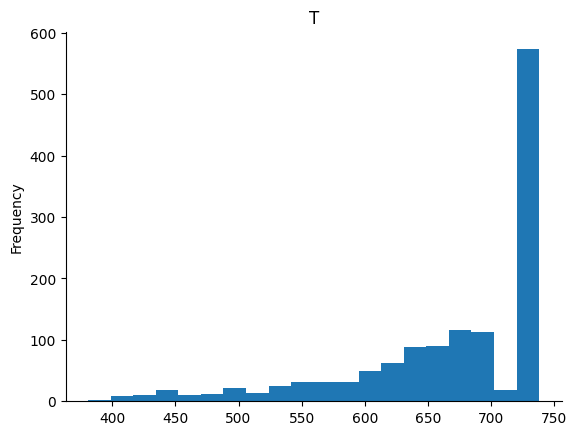

In [39]:
# @title T

from matplotlib import pyplot as plt
clv['T'].plot(kind='hist', bins=20, title='T')
plt.gca().spines[['top', 'right',]].set_visible(False)

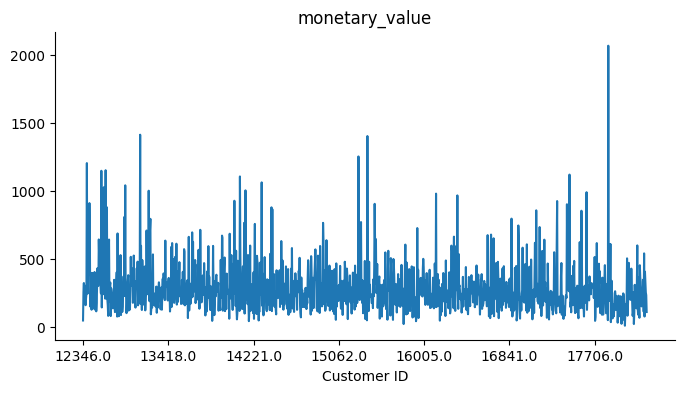

In [38]:
# @title monetary_value

from matplotlib import pyplot as plt
clv['monetary_value'].plot(kind='line', figsize=(8, 4), title='monetary_value')
plt.gca().spines[['top', 'right']].set_visible(False)